# Regression Task: Boston Housing

In this project, we develop a regression model and end-to-end machine learning pipeline to predict median home values in Boston. The model is tuned using cross validation and evaluated on unseen data.

## Step 1. Setup

We start by importing data science and machine learning modules and configuring a few settings. In particular, seeding the random number generation used throughout this project will help us reproduce our results.

In [5]:
import sklearn
import numpy as np
import pandas as pd
import os

# Seed numpy random number generation
SEED = 42
np.random.seed(SEED)

# Setup matplotlib for graph display
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Step 2. Obtaining Data

Next we obtain the UCI Machine Learning Repository's house price dataset, which contains housing data collected in 1978 from various suburbs in Boston, Massachusetts.

In [6]:
def load_data():
  return pd.read_csv('housing.csv', delim_whitespace=True)

In [7]:
data = load_data()
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B1000', 'LSTAT', 'MEDV']
data.columns = column_names

In [8]:
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B1000,LSTAT,MEDV
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
501,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
502,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
503,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


An overview of the dataset reveals that the CHAS and RAD features are the only two represented as integers, a distinction worth exploring down the line. 

We can also see that there are no missing values, which we will verify later.

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     505 non-null    float64
 1   ZN       505 non-null    float64
 2   INDUS    505 non-null    float64
 3   CHAS     505 non-null    int64  
 4   NOX      505 non-null    float64
 5   RM       505 non-null    float64
 6   AGE      505 non-null    float64
 7   DIS      505 non-null    float64
 8   RAD      505 non-null    int64  
 9   TAX      505 non-null    float64
 10  PTRATIO  505 non-null    float64
 11  B1000    505 non-null    float64
 12  LSTAT    505 non-null    float64
 13  MEDV     505 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.4 KB


A quick statistical summary helps us get a sense of the datapoints. From a glance, CRIM appears extremely skewed -- the quartiles grow tepidly at first and then explode from the single digits to nearly 90!

In [10]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B1000,LSTAT,MEDV
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,3.620667,11.350495,11.154257,0.069307,0.554728,6.284059,68.581584,3.794459,9.566337,408.459406,18.461782,356.594376,12.668257,22.529901
std,8.608572,23.343704,6.855868,0.254227,0.115990,0.703195,28.176371,2.107757,8.707553,168.629992,2.162520,91.367787,7.139950,9.205991
min,0.009060,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082210,0.000000,5.190000,0.000000,0.449000,5.885000,45.000000,2.100000,4.000000,279.000000,17.400000,375.330000,7.010000,17.000000
50%,0.259150,0.000000,9.690000,0.000000,0.538000,6.208000,77.700000,3.199200,5.000000,330.000000,19.100000,391.430000,11.380000,21.200000
75%,3.678220,12.500000,18.100000,0.000000,0.624000,6.625000,94.100000,5.211900,24.000000,666.000000,20.200000,396.210000,16.960000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


But is the result of an outlier, or is the distribution actually right-skewed? We generate histograms to look at each variable's distribution.

Here we can see that the shape of the data varies widely -- RM is reasonably balanced, while others like B1000 are highly skewed.

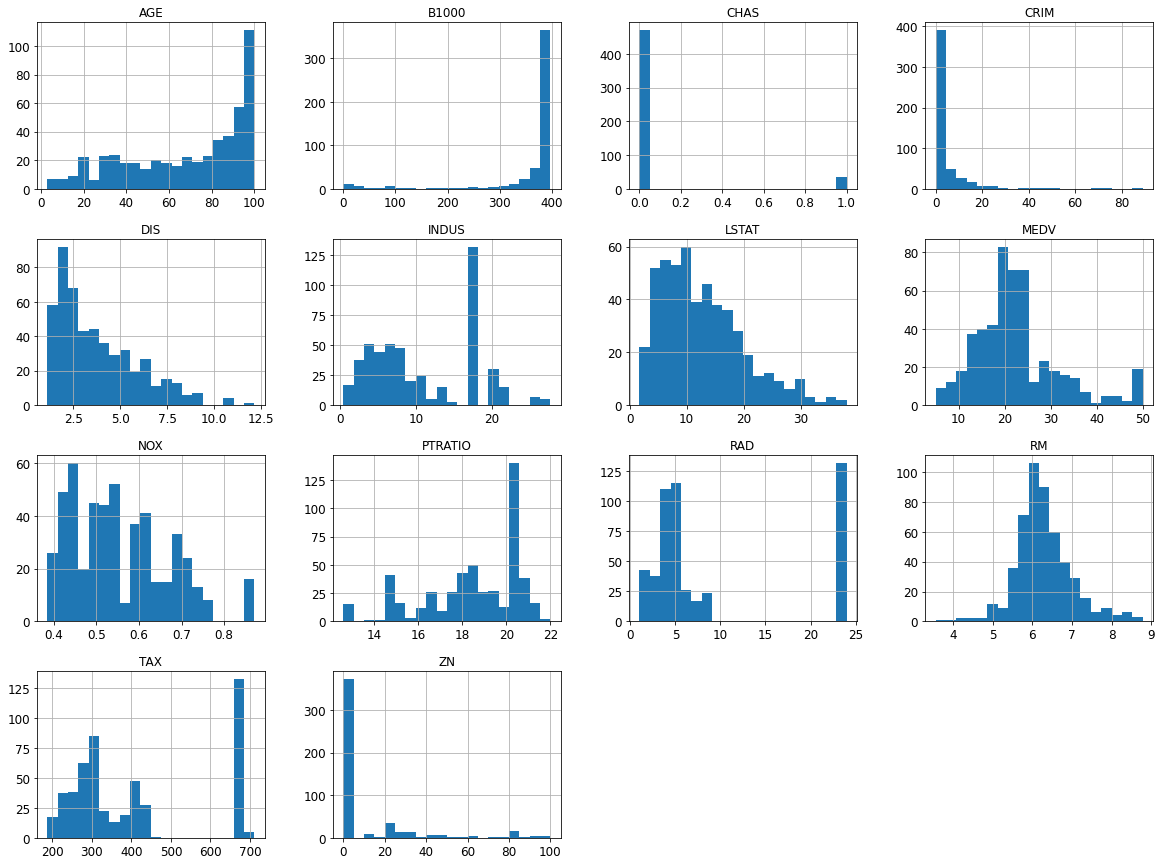

In [11]:
data.hist(bins=20, figsize=(20,15))
plt.show()

Of interest is the distribution of MEDV (median home values), the target of our prediction modeling. There is some skew to the data, but it is not extreme.

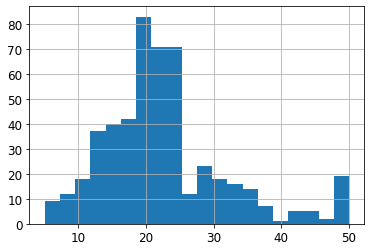

In [12]:
label_name = 'MEDV'
data[label_name].hist(bins=20, figsize=(6,4))
plt.show()

Next we split the data into train and test sets. To avoid data snooping bias, we hold off on touching the test set until we have a final model ready to evaluate.

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=SEED)

print(train.shape)
print(test.shape)

(404, 14)
(101, 14)


## Step 3. Data Visualization

The **correlation coefficients** indicate the strength of the statistical relationship between variables.

In [14]:
corr_matrix = train.corr()

In [15]:
corr_scores = pd.DataFrame(corr_matrix[label_name].sort_values(ascending=False))
corr_scores

,MEDV
MEDV,1.000000
RM,0.707243
B1000,0.355831
ZN,0.312550
DIS,0.210648
CHAS,0.191191
AGE,-0.332688
RAD,-0.379681
CRIM,-0.383341
NOX,-0.406023


Let's take a look at the strongest individual predictors for median home value.

In [16]:
# Top positive and top two negative features
corr_names = corr_scores.index[0:2].tolist() + corr_scores.index[-2::].tolist()

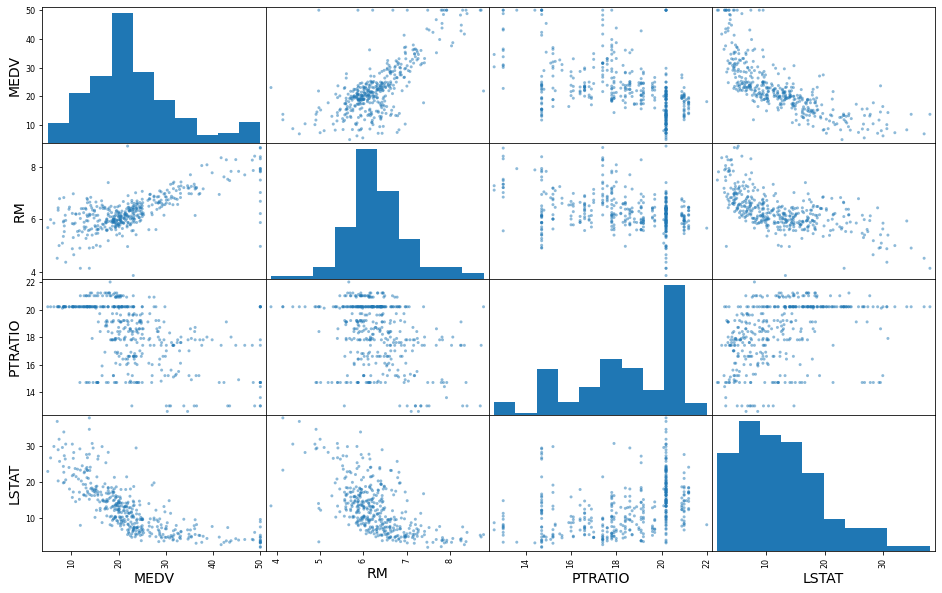

In [17]:
from pandas.plotting import scatter_matrix
scatter_matrix(train[corr_names], figsize=(16, 10))
plt.show()

Of these, we can conjecture that RM and LSTAT are likely to have significant predictive value with respect to MEDV.

## Step 4. Data Preprocessing

We start by dividing the dataset into features used for prediction and the prediction labels themselves.

In [18]:
features = train.drop(label_name, axis=1)
labels = train[label_name].copy()

Our inspection earlier showed no missing values for any of the variables. Regardless, we can sum up the number of `None` and `NaN` values for each column to verify.

In [51]:
features.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B1000      0
LSTAT      0
dtype: int64

In [20]:
labels.isna().sum()

0

A key step is to construct a **pipeline** to facilitate the data transformation process. We use Scikit-Learn's ColumnTransformer to perform standardization on numerical features and ordinal encoding on RAD, an ordinal categorical feature. CHAS is left in its binary encoding, which is the appropriate representation.

Additionally, we include a simple imputer in case future data contains missing values. We employ a median value strategy, which learns better "center" datapoints for skewed distributions.

In [21]:
# Drop the label to obtain only names of features
feature_names = np.array(column_names)[np.isin(np.array(column_names), label_name, invert=True)]

# Obtain names of numerical features
num_feature_names = np.array(feature_names)[np.isin(np.array(feature_names), ['CHAS', 'RAD'], invert=True)]
num_feature_names

array(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO',
       'B1000', 'LSTAT'], dtype='<U7')

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

full_pipeline = ColumnTransformer(transformers=[
  ('num', num_pipeline, num_feature_names),
  ('cat_ord', OrdinalEncoder(), ['RAD'])
], remainder='passthrough')

In [23]:
column_names_reordered = np.concatenate((num_feature_names, ['RAD', 'CHAS']))
features_prepared = pd.DataFrame(full_pipeline.fit_transform(features), columns=column_names_reordered)

The rescaled numerical variables (and untouched CHAS) have the same shape as before, while RAD's discrete categories have been made consecutive.

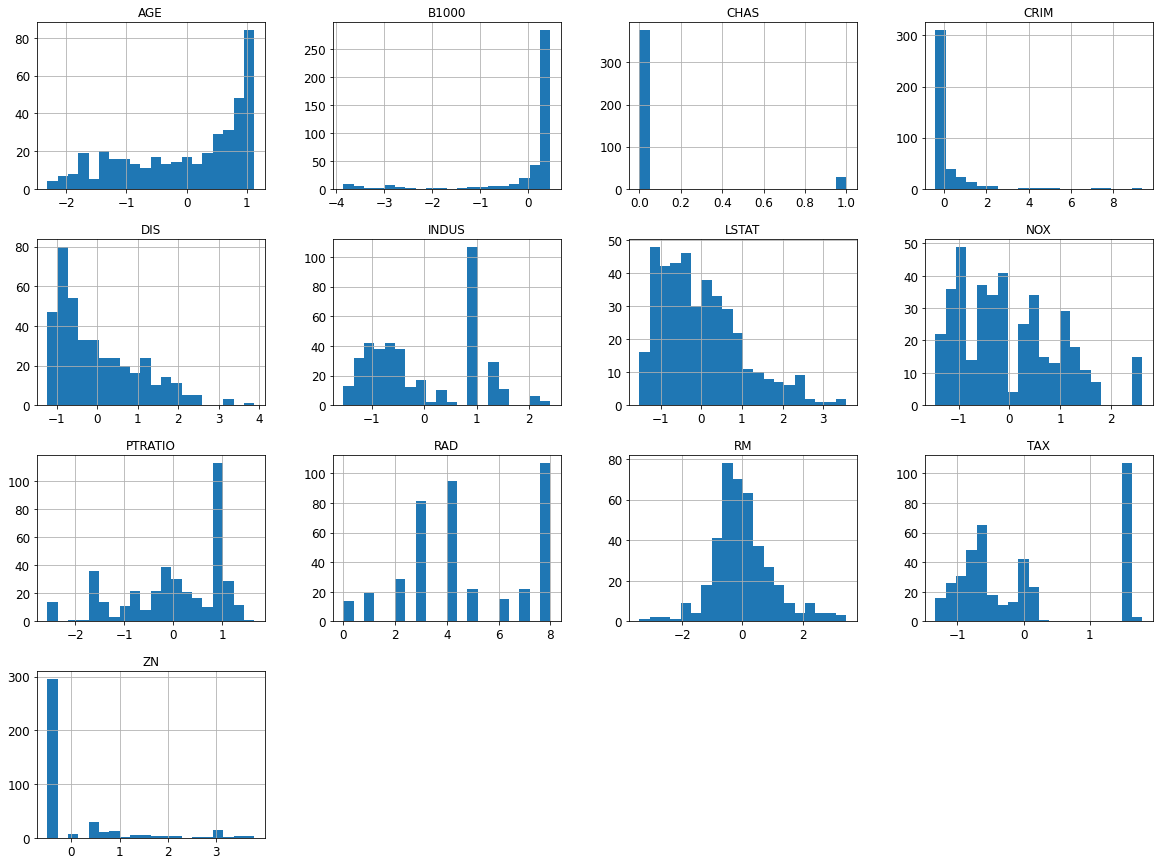

In [24]:
pd.DataFrame(features_prepared).hist(bins=20, figsize=(20,15))
plt.show()

## Step 5. Model Selection

To ensure that our test set is an unbiased estimator of our model performance, we avoid using it for the selection stage. Instead, we can perform **k-fold cross validation** by partitioning our training set into "folds", training k models on all but one, and validating each on the left-out fold.

We start by defining functions to perform cross validation and display the results.

In [25]:
def print_scores(scores):
  print("RMSEs: ", np.around(scores, 4))
  print("Mean: ", np.around(scores.mean(), 4))
  print("Standard Deviation: ", np.around(scores.std(), 4))

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.testing import ignore_warnings

@ignore_warnings(category=ConvergenceWarning)
def cross_validate(estimator):
  scores = cross_val_score(estimator, features_prepared, labels,
                         scoring="neg_mean_squared_error", cv=5)
  rmse_scores = np.sqrt(-scores)
  print_scores(rmse_scores)
  return rmse_scores.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


From here we can fit different machine leaning models and compare them. Linear regression is straightforward and a good starting point in our search.

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_rmse = cross_validate(lin_reg)

RMSEs:  [4.3465 5.4933 6.159  4.3356 5.0431]
Mean:  5.0755
Standard Deviation:  0.6969


Unlike linear regression, multilayer perceptrons are capable of learning nonlinear functions, but may require hyperparameter tuning to learn effectively. We can see that without any changes to the default hyperparameters, MLP performs worse on average than the linear model.

In [28]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(random_state=SEED)
mlp_rmse = cross_validate(mlp_reg)

RMSEs:  [5.0168 5.6386 6.4622 5.1766 4.3503]
Mean:  5.3289
Standard Deviation:  0.7012


Next we turn to tree-based learning, which can learn nonlinear patterns, sometimes without too much additional tuning. 

Starting with a basic decision tree, we can already see improvement over previous models. Can we push its capabilities further?

In [29]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=SEED)
tree_rmse = cross_validate(tree_reg)

RMSEs:  [3.8989 5.9497 5.2036 4.4045 4.4166]
Mean:  4.7746
Standard Deviation:  0.7207


One potential avenue is an **ensemble model**, which takes multiple machine learning models and combines their predictions to form one result. Random forest, extra trees, and gradient boosting regressors are all variants on this idea, aggregating the predictions of multiple decision trees.

In [30]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=SEED)
forest_rmse = cross_validate(forest_reg)

RMSEs:  [3.568  4.0354 4.7618 3.4732 3.7371]
Mean:  3.9151
Standard Deviation:  0.4645


In [31]:
from sklearn.ensemble import ExtraTreesRegressor

et_reg = ExtraTreesRegressor(n_estimators=100, random_state=SEED)
et_rmse = cross_validate(et_reg)

RMSEs:  [3.309  3.4213 4.8388 3.304  3.4593]
Mean:  3.6665
Standard Deviation:  0.5893


In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(n_estimators=100, random_state=SEED)
gb_rmse = cross_validate(gb_reg)

RMSEs:  [3.2335 3.0367 4.2389 3.5166 3.4459]
Mean:  3.4943
Standard Deviation:  0.4086


## Step 6. Model Tuning


We select the **gradient boosting regressor** as our model and perform some fine-tuning with the help of random search.

In [33]:
model = GradientBoostingRegressor(random_state=SEED)

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

params = {
  'learning_rate': uniform(0.001, 0.1),
  'n_estimators': randint(low=50, high=200),
  'max_features': randint(low=1, high=features.shape[1]),
  'max_depth': randint(low=1, high=20)
}


In [35]:
rnd_search = RandomizedSearchCV(model, param_distributions=params,
                                 n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
rnd_search.fit(features_prepared, labels);

Now we can discover the best combination of hyperparameters for our model, and the resulting mean cross validation score. Lastly, we can perform a final evaluation using the test set we set aside earlier.

In [61]:
rnd_search.best_params_

{'learning_rate': 0.07400393165618185,
 'max_depth': 3,
 'max_features': 12,
 'n_estimators': 193}

In [37]:
cv_rmse = np.sqrt(-rnd_search.best_score_)
print("Mean CV Score: ", np.around(cv_rmse, 4))

Mean CV Score:  3.4873


In [42]:
from sklearn.metrics import mean_squared_error

features_test = test.drop(label_name, axis=1)
labels_test = test[label_name].copy()

features_test_prepared = full_pipeline.transform(features_test)
final_model = rnd_search.best_estimator_
predictions = final_model.predict(features_test_prepared)

test_rmse = np.sqrt(mean_squared_error(labels_test, predictions))
print("Mean Test Score: ", np.around(test_rmse, 4))

Mean Test Score:  2.3647


## Step 7. Our Solution

This project represents a complete, end-to-end machine learning solution for predicting Boston home values. The chart below visualizes the iterative nature of the process, which consisted of trying multiple models, selecting one and fine-tuning it, and applying it to unseen data.

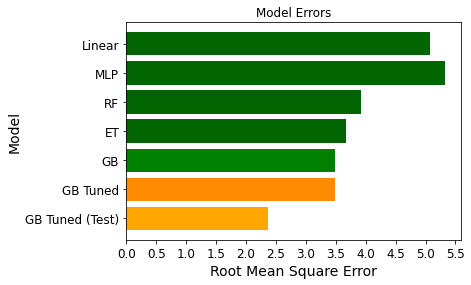

In [55]:
model_names = ['Linear', 'MLP', 'RF', 'ET', 'GB', 'GB Tuned', 'GB Tuned (Test)']
model_scores = [lin_rmse, mlp_rmse, forest_rmse, et_rmse, gb_rmse, cv_rmse, test_rmse]
model_colors = ['darkgreen', 'darkgreen', 'darkgreen', 'darkgreen', 'green', 'darkorange', 'orange']
plt.barh(model_names[::-1], model_scores[::-1], color=model_colors[::-1])
plt.xlabel('Root Mean Square Error')
plt.ylabel('Model')
plt.xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])
plt.title('Model Errors')
plt.show()

As the MEDV variable represents values in the thousands, our cross-validated root mean square error of 3.4873 can be interpreted as follows:

> Roughly speaking, our model can predict median home values with an average error of $3487.30.

However, this is an inexact interpretation due to RMSE's extra weighting of outliers.

As businesses and governments seek to leverage machine learning models for consequential decisions, **Explainable AI** has become increasingly important. Luckily, using tree models like gradient boosting allows us to shed some light on the influence each feature holds over the outcome.

Below are the weights, in percentages, the top five relevant features have in forming a prediction of median home values. We can see that our hypothesis that average room count and lower status population proportion are the most relevant features was correct. 

In [43]:
weights = np.around(final_model.feature_importances_*100, 2)
pd.DataFrame(weights, columns=['Weight %'], index=column_names_reordered).sort_values(by=['Weight %'], ascending=False).head()

,Weight %
RM,42.89
LSTAT,34.95
DIS,8.30
CRIM,3.30
NOX,3.03


# Step 8. Deploying Model

As a final step, we persist our model for deploying to cloud services or other Python programs.

In [46]:
full_pipeline_prediction = Pipeline([
  ('preprocessor', full_pipeline),
  ('predictor', final_model)
])

In [47]:
import joblib
joblib.dump(full_pipeline_prediction, "model.pkl")

['model.pkl']